In [1]:
import pandas as pd

In [2]:
train_df =pd.read_csv('比赛训练集.csv',encoding = 'gbk')
test_df = pd.read_csv('比赛测试集.csv',encoding = 'gbk')

In [3]:
train_df.isnull().sum()

编号            0
性别            0
出生年份          0
体重指数          0
糖尿病家族史        0
舒张压         247
口服耐糖量测试       0
胰岛素释放实验       0
肱三头肌皮褶厚度      0
患有糖尿病标识       0
dtype: int64

In [4]:
test_df.isnull().sum()

编号           0
性别           0
出生年份         0
体重指数         0
糖尿病家族史       0
舒张压         49
口服耐糖量测试      0
胰岛素释放实验      0
肱三头肌皮褶厚度     0
dtype: int64

口服耐糖量测试为-1的也属于缺失值，胰岛素释放实验为0的也属于缺失值，肱三头肌厚度为0的也属于缺失值，待后面在处理。

In [5]:
###字段相关性
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['FangSong']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

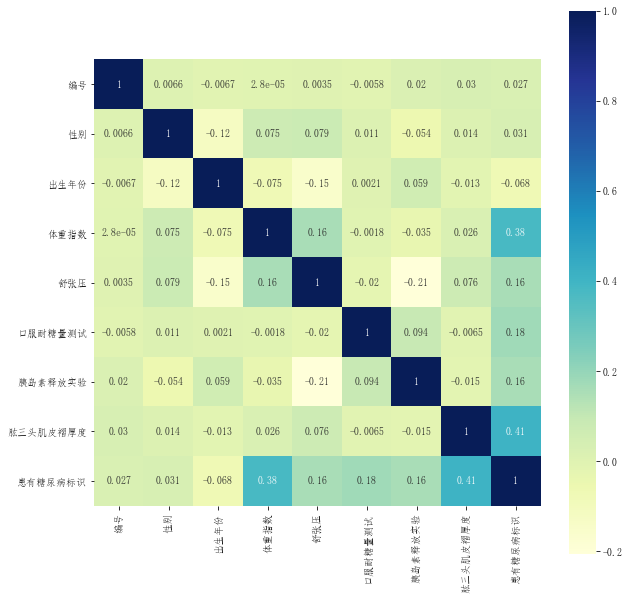

In [6]:
plt.subplots(figsize=(10,10))
sns.heatmap(train_df.corr(method='pearson'), annot=True, vmax=1, square=True, cmap='YlGnBu')
plt.savefig('train_pearson.jpg', dpi=800)

 从热力图可以看出，训练集中体重指数和肱三头肌皮褶厚度与标签的相关性相对较高，肱三头肌皮褶厚度与标签的相关性最高。各字段之间的相关性普遍不高。`m

### 特征工程

In [7]:
def BMI(a):
    if a < 18.5:
        return 0
    elif 18.5 <= a <=24:
        return 1
    elif 24 <a <= 27:
        return 2
    elif 27 < a <= 32:
        return 3
    else:
        return 4
data1 =train_df
test_df['患有糖尿病标识']=-1
data2 =test_df
data=pd.concat([data1,data2],axis=0,ignore_index=True)
data['BMI'] = data['体重指数'].apply(BMI)
data['出生年份'] = 2022 - data['出生年份']
def FHOD(a):
    if a=='无记录':
        return 0
    elif a=='叔叔或者姑姑有一方患有糖尿病' or a=='叔叔或姑姑有一方患有糖尿病':
        return 1
    else:
        return 2
data['糖尿病家族史'] = data['糖尿病家族史'].apply(FHOD)
data['舒张压'] = data['舒张压'].fillna(-1)
"""
舒张压范围是60-90
"""
def DBP(a):
    if a< 60:
        return 0
    elif 60 <= a <= 90:
        return 1
    elif a > 90:
        return 2
    else:
        return a
data['DBP'] = data['舒张压'].apply(DBP)
data

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识,BMI,DBP
0,1,0,26,30.1,0,106.0,3.818,7.89,0.0,0,3,2
1,2,0,34,27.5,0,84.0,-1.000,0.00,14.7,0,3,1
2,3,1,34,36.5,0,85.0,7.131,0.00,40.1,1,4,1
3,4,1,30,29.5,0,91.0,7.041,0.00,0.0,0,3,2
4,5,0,24,42.0,1,-1.0,7.134,0.00,0.0,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6065,996,1,32,50.1,0,87.0,5.125,0.00,0.0,-1,4,1
6066,997,0,30,56.3,0,87.0,7.695,0.00,0.0,-1,4,1
6067,998,1,30,23.8,0,85.0,3.194,7.50,0.0,-1,1,1
6068,999,0,22,53.1,0,95.0,8.226,7.55,0.0,-1,4,2


In [8]:
train=data[data['患有糖尿病标识'] !=-1]
test=data[data['患有糖尿病标识'] ==-1]
train_label=train['患有糖尿病标识']
train=train.drop(['编号','患有糖尿病标识'],axis=1)
test=test.drop(['编号','患有糖尿病标识'],axis=1)

### lightGBM

In [10]:
import lightgbm 
def select_by_lgb(train_data,train_label,test_data,random_state=2022,metric='auc',num_round=300):
    clf=lightgbm
    train_matrix=clf.Dataset(train_data,label=train_label)

    params={
            'epoch':4,
            'boosting_type': 'gbdt',  
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': metric,
            'seed': 2020,
            'nthread':-1 }
    model=clf.train(params,train_matrix,num_round)
    pre_y=model.predict(test_data)
    return pre_y

D:\anaconda\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
D:\anaconda\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
D:\anaconda\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [11]:
test_data=select_by_lgb(train,train_label,test)
pre_y=pd.DataFrame(test_data)
pre_y['label']=pre_y[0].apply(lambda x:1 if x>0.5 else 0)
result=pd.read_csv('提交示例.csv')
result['label']=pre_y['label']
result.to_csv('baseline.csv',index=False)

[LightGBM] [Warning] Unknown parameter: epoch
[LightGBM] [Warning] Unknown parameter: epoch
[LightGBM] [Info] Number of positive: 1936, number of negative: 3134
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381854 -> initscore=-0.481686
[LightGBM] [Info] Start training from score -0.481686


####结果96244

#### 决策树

In [13]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(train, train_label)
y_pre=model.predict(test)
result=pd.read_csv('提交示例.csv')
result['label']=y_pre
result.to_csv('result-de.csv',index=False)

###结果93141

### 逻辑回归

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import numpy as np

In [17]:
model = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2', multi_class='ovr',max_iter=10000))
params = {
    'logisticregression__solver': ['liblinear', 'sag', 'saga', 'newton-cg', 'lbfgs'],
    'logisticregression__C': np.linspace(0.1, 1, 10)
}

In [39]:
X = train
y = train_label
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=1)
grid.fit(X=X, y=y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           multi_class='ovr'))]),
             param_grid={'logisticregression__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'logisticregression__solver': ['liblinear', 'sag',
                                                        'saga', 'newton-cg',
                                                        'lbfgs']},
             verbose=1)

In [43]:

test['label'] = grid.predict(test)
test.head()

,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,BMI,DBP,label
5070,0,35,33.1,0,72.0,6.586,24.16,2.94,4,1,0
5071,0,24,20.6,1,68.0,3.861,0.00,0.00,1,1,0
5072,1,43,42.1,0,98.0,5.713,0.00,3.53,4,2,0
5073,0,23,34.6,0,66.0,4.684,0.00,3.14,4,1,0
5074,0,25,27.7,0,89.0,7.948,14.65,2.65,3,1,0


In [44]:
test.index.name = 'uuid'
test['label'].to_csv(path_or_buf='submit.csv', index='uuid')

###结果77